# Latency CDF

In [1]:
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pycountry
import os

def country_name(country_iso):
    return pycountry.countries.get(alpha_2=country_iso).name

def filter_for(df, name, value):
    return df.loc[df[name] == value]

def filter_for_range(df, name, lower_bound, upper_bound):
    return df[(df[name] >= lower_bound) & (df[name] < upper_bound)]

In [2]:
tls_data_file = "./parquet/tls_data.parquet"
probes_data_file = "./parquet/ripe_atlas_probe_data.parquet"

tls_data = pd.read_parquet(tls_data_file)
probes = pd.read_parquet(probes_data_file).set_index('id')
df = tls_data.join(probes, on='prb_id')

df

,af,dst_name,dst_port,src_name,method,msm_id,msm_name,prb_id,rt,ttc,timestamp,source_platform,ipv4,asn,longitude,latitude,country
0,4,atlas.ripe.net,443,180.150.31.130,TLS,14002,SSLCert,1004828,514.880933,256.740837,1664818711,RIPE ATLAS (builtin tls),206.83.112.200,14593.0,151.5885,-32.9085,AU
1,4,atlas.ripe.net,443,180.150.31.130,TLS,14002,SSLCert,1004828,510.178742,254.042678,1664861910,RIPE ATLAS (builtin tls),206.83.112.200,14593.0,151.5885,-32.9085,AU
2,4,atlas.ripe.net,443,180.150.31.130,TLS,14002,SSLCert,1004828,522.505294,259.568981,1664905110,RIPE ATLAS (builtin tls),206.83.112.200,14593.0,151.5885,-32.9085,AU
3,4,atlas.ripe.net,443,180.150.31.130,TLS,14002,SSLCert,1004828,509.919590,253.841243,1664991511,RIPE ATLAS (builtin tls),206.83.112.200,14593.0,151.5885,-32.9085,AU
4,4,atlas.ripe.net,443,180.150.31.130,TLS,14002,SSLCert,1004828,524.197979,263.020576,1664948309,RIPE ATLAS (builtin tls),206.83.112.200,14593.0,151.5885,-32.9085,AU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312643,4,atlas.ripe.net,443,145.224.67.126,TLS,14002,SSLCert,1297,99.269396,55.493388,1719181735,RIPE ATLAS (builtin tls),145.224.66.114,14593.0,-0.9685,51.7505,GB
312644,4,atlas.ripe.net,443,145.224.66.235,TLS,14002,SSLCert,1297,85.492241,38.236423,1719354534,RIPE ATLAS (builtin tls),145.224.66.114,14593.0,-0.9685,51.7505,GB
312645,4,atlas.ripe.net,443,145.224.66.184,TLS,14002,SSLCert,1297,85.246481,52.818443,1719959334,RIPE ATLAS (builtin tls),145.224.66.114,14593.0,-0.9685,51.7505,GB
312646,4,atlas.ripe.net,443,145.224.66.184,TLS,14002,SSLCert,1297,91.639314,43.911177,1720477733,RIPE ATLAS (builtin tls),145.224.66.114,14593.0,-0.9685,51.7505,GB


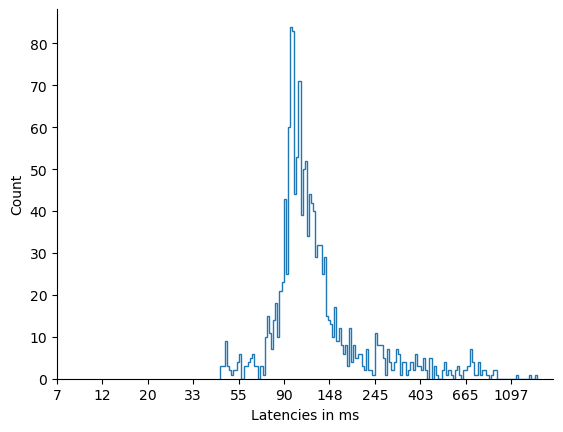

<Figure size 640x480 with 0 Axes>

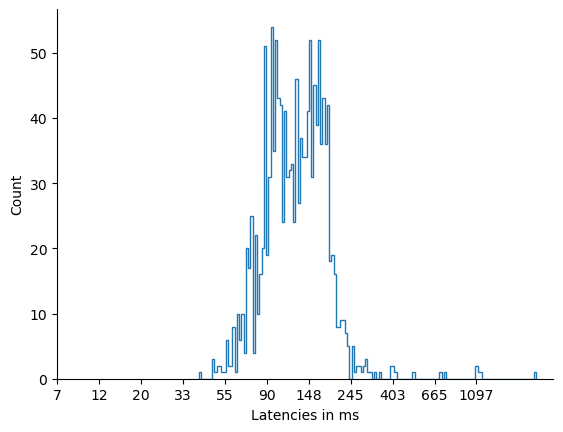

<Figure size 640x480 with 0 Axes>

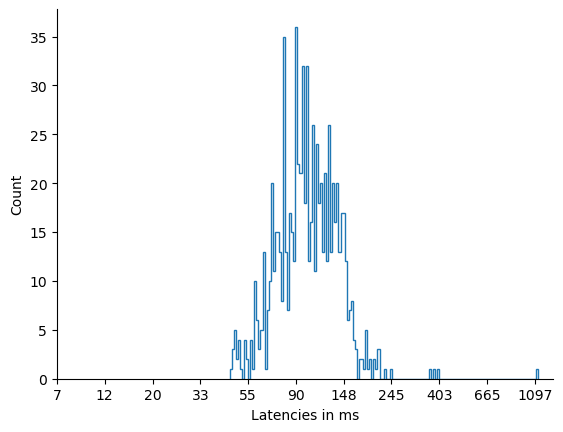

<Figure size 640x480 with 0 Axes>

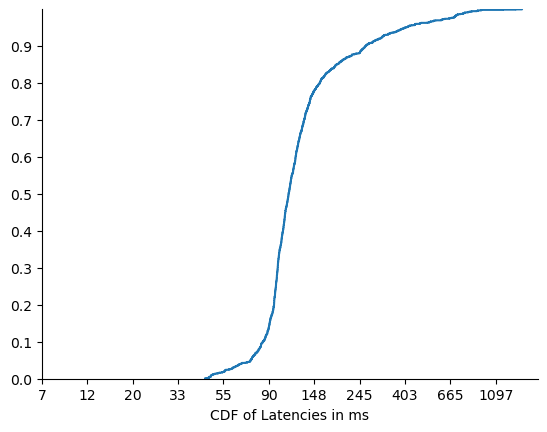

<Figure size 640x480 with 0 Axes>

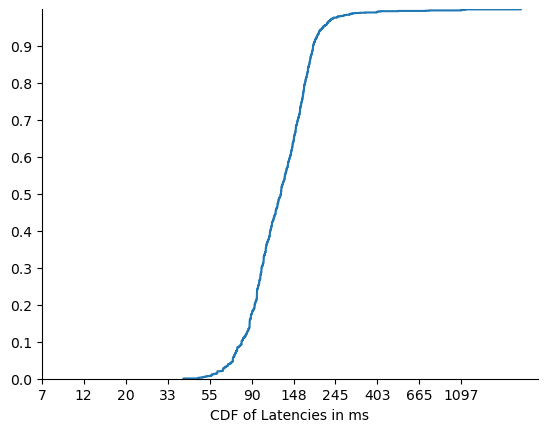

<Figure size 640x480 with 0 Axes>

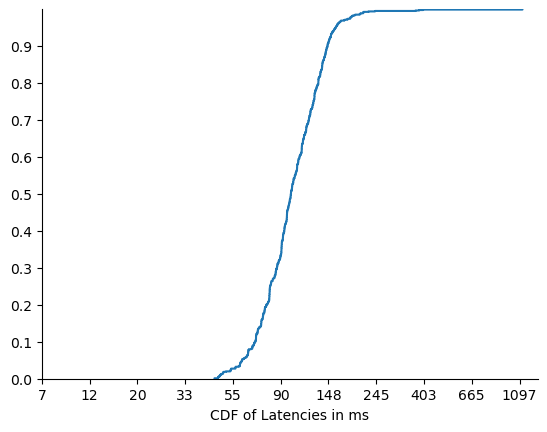

<Figure size 640x480 with 0 Axes>

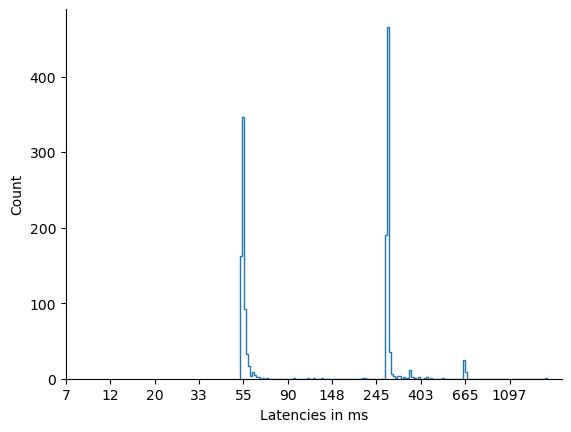

<Figure size 640x480 with 0 Axes>

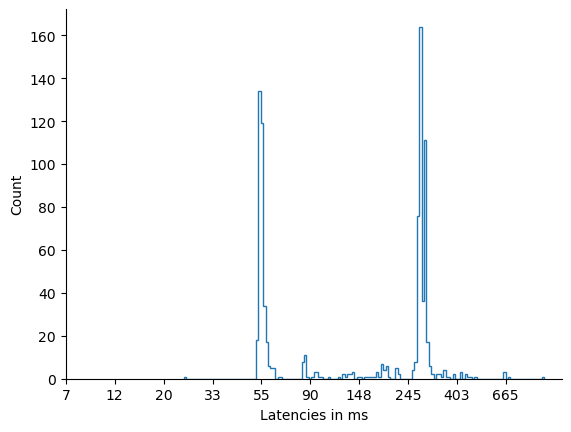

<Figure size 640x480 with 0 Axes>

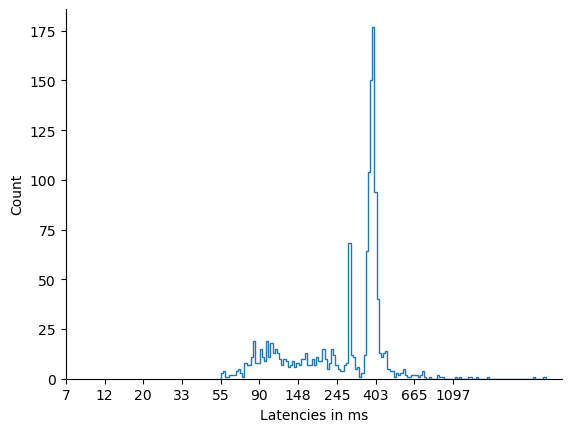

<Figure size 640x480 with 0 Axes>

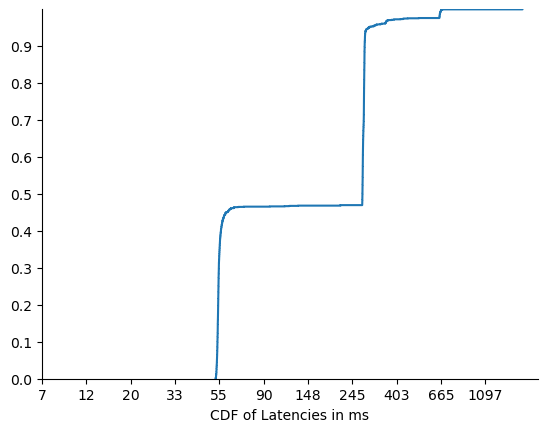

<Figure size 640x480 with 0 Axes>

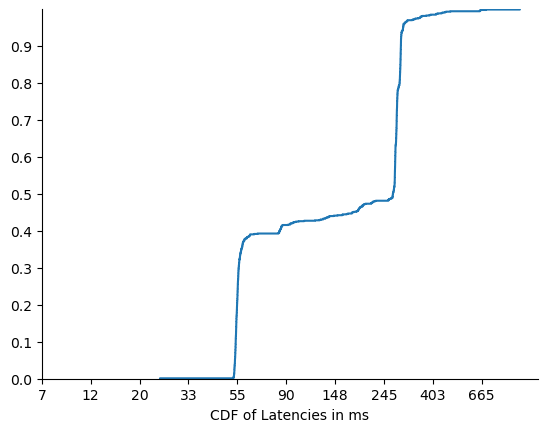

<Figure size 640x480 with 0 Axes>

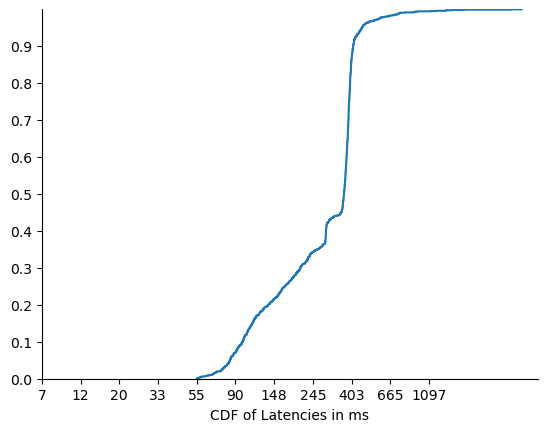

<Figure size 640x480 with 0 Axes>

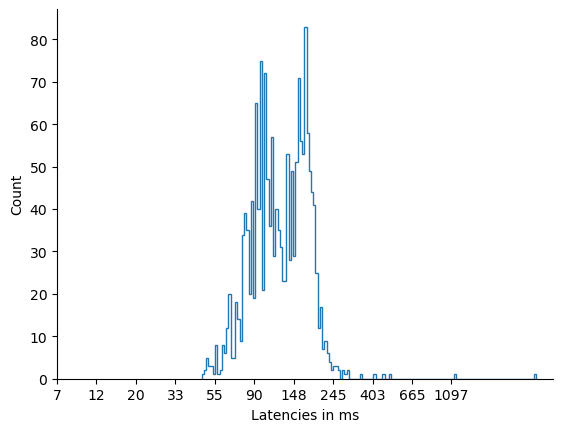

<Figure size 640x480 with 0 Axes>

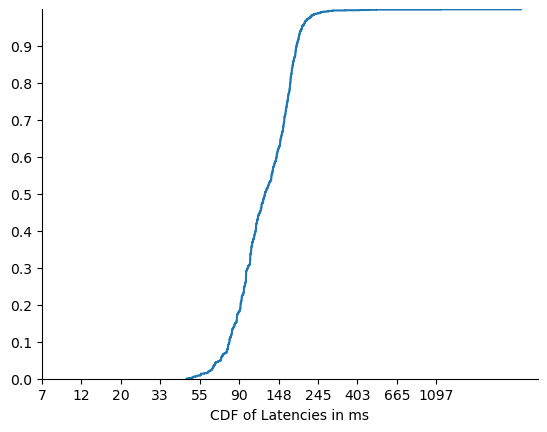

<Figure size 640x480 with 0 Axes>

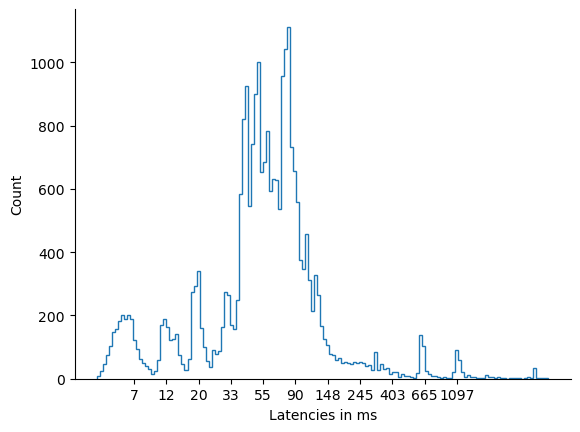

<Figure size 640x480 with 0 Axes>

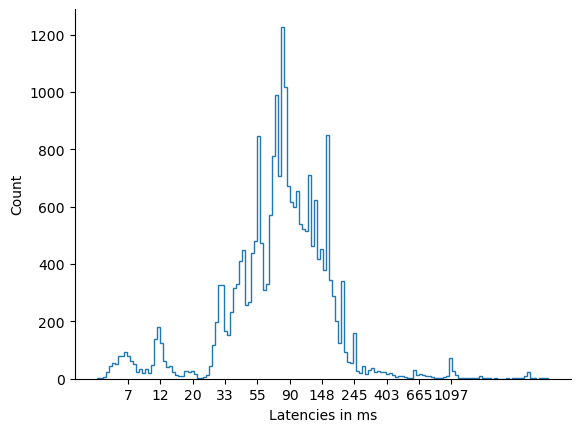

<Figure size 640x480 with 0 Axes>

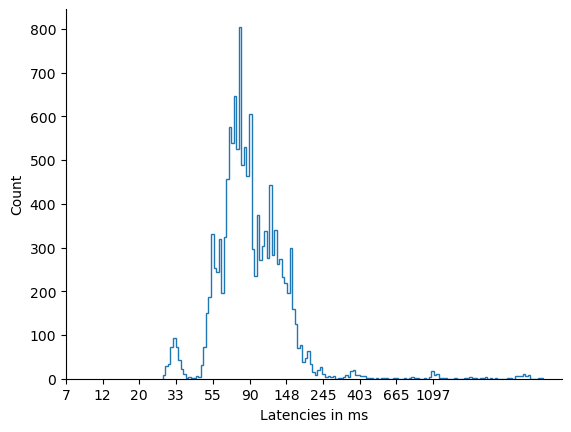

<Figure size 640x480 with 0 Axes>

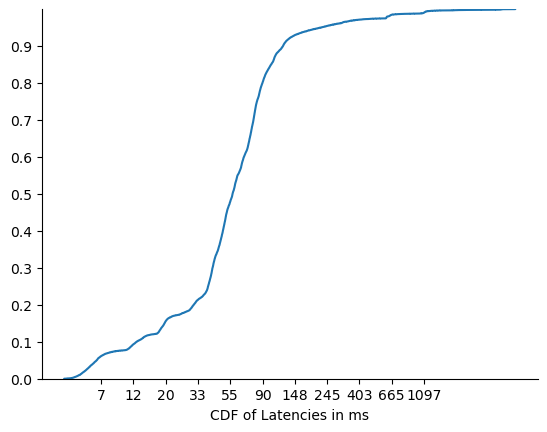

<Figure size 640x480 with 0 Axes>

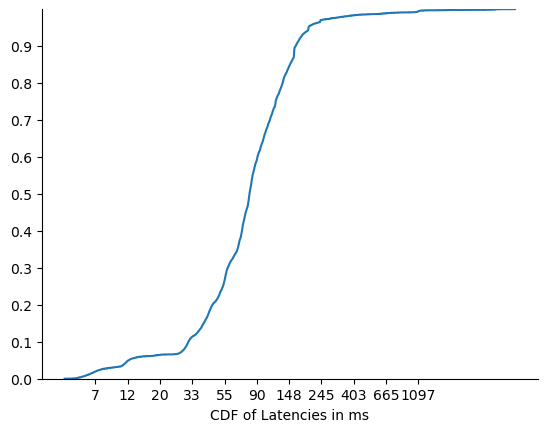

<Figure size 640x480 with 0 Axes>

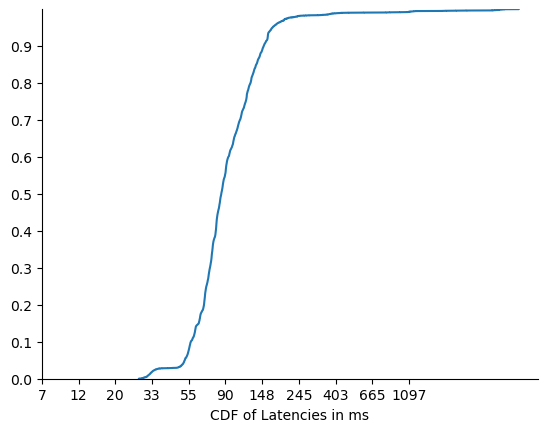

<Figure size 640x480 with 0 Axes>

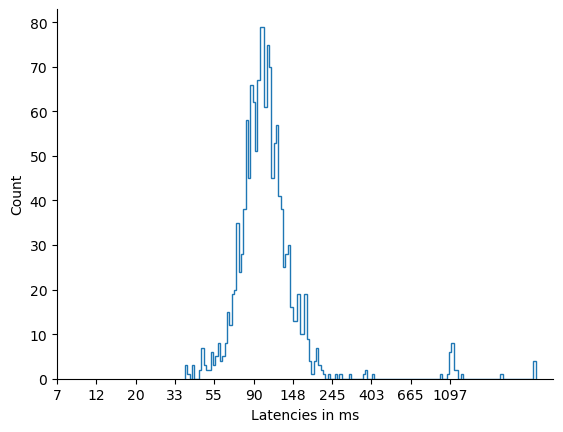

<Figure size 640x480 with 0 Axes>

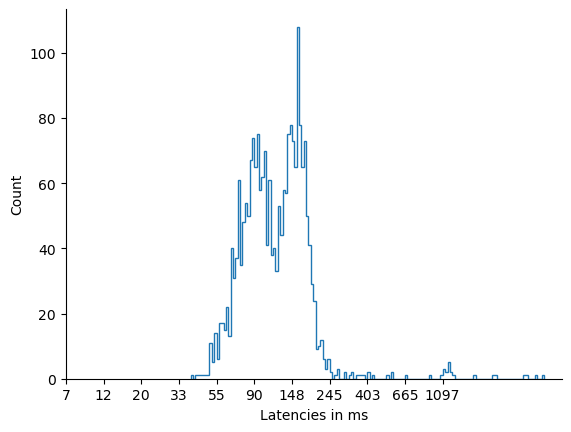

<Figure size 640x480 with 0 Axes>

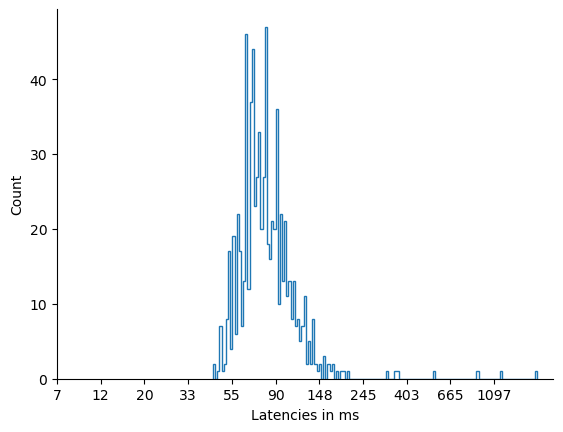

<Figure size 640x480 with 0 Axes>

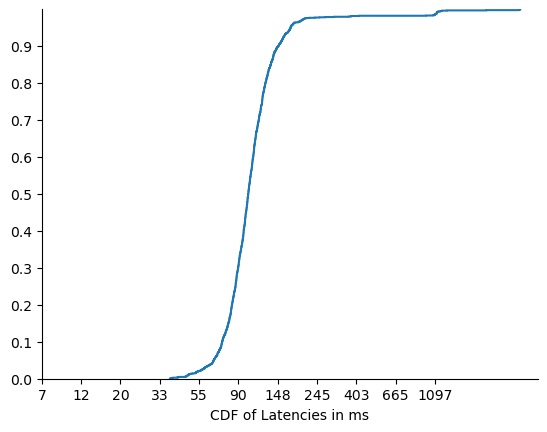

<Figure size 640x480 with 0 Axes>

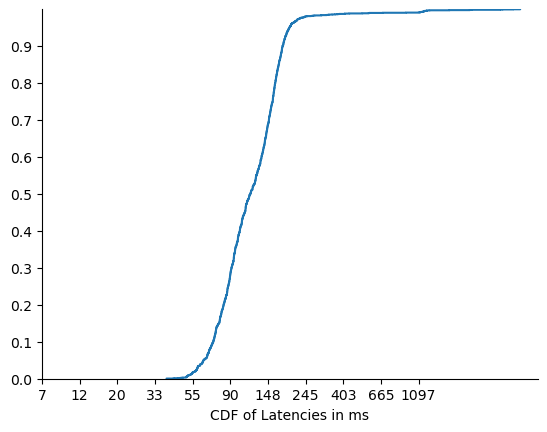

<Figure size 640x480 with 0 Axes>

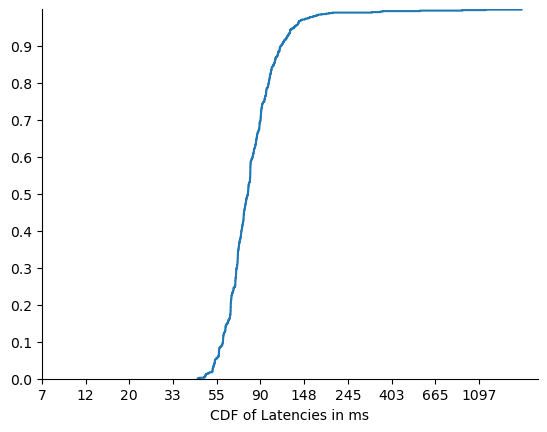

<Figure size 640x480 with 0 Axes>

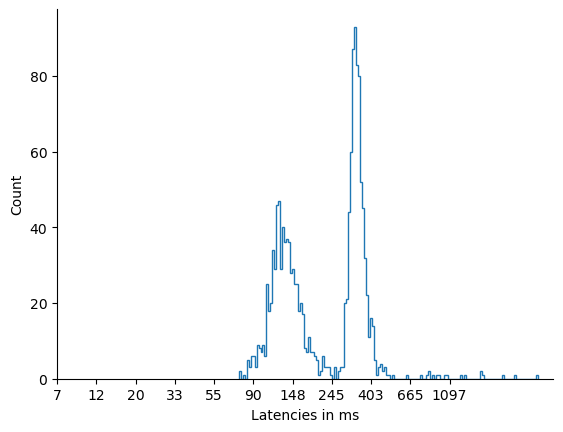

<Figure size 640x480 with 0 Axes>

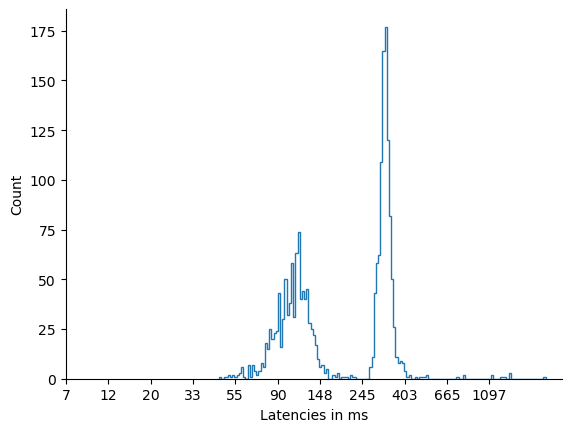

<Figure size 640x480 with 0 Axes>

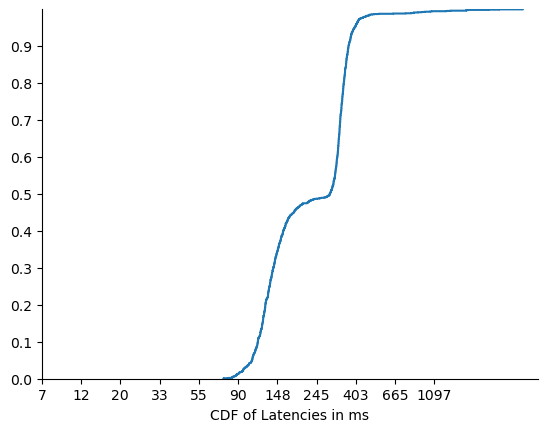

<Figure size 640x480 with 0 Axes>

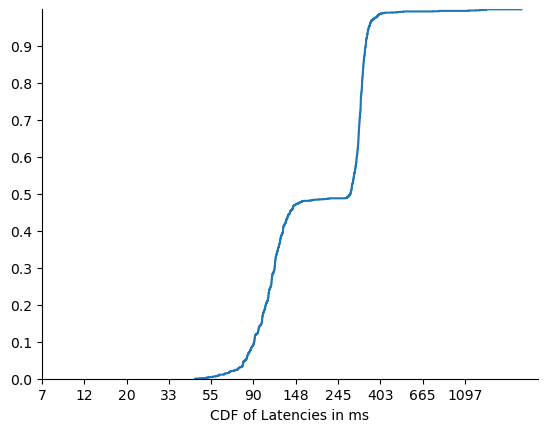

<Figure size 640x480 with 0 Axes>

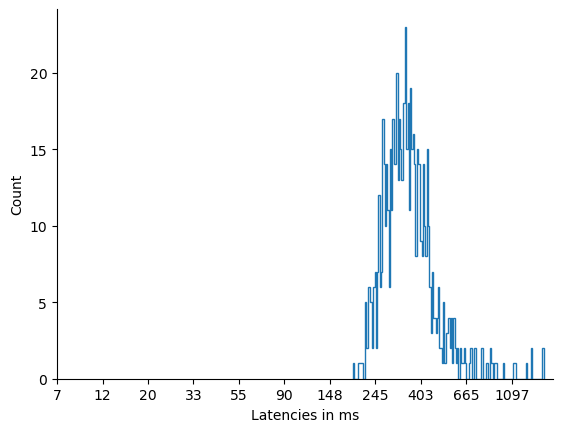

<Figure size 640x480 with 0 Axes>

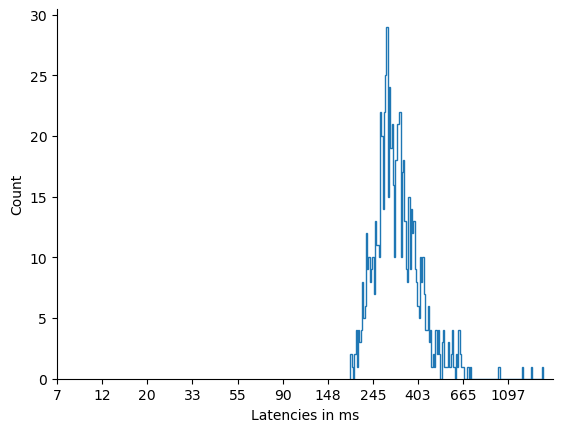

<Figure size 640x480 with 0 Axes>

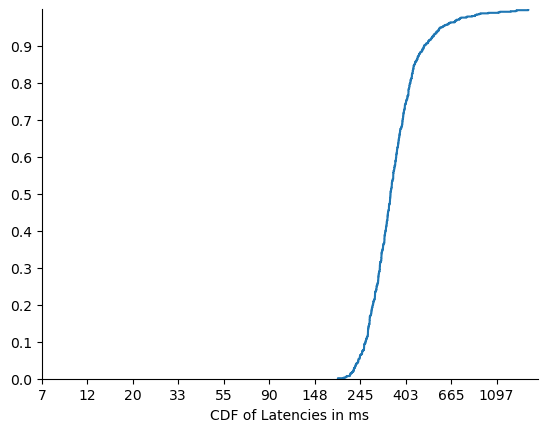

<Figure size 640x480 with 0 Axes>

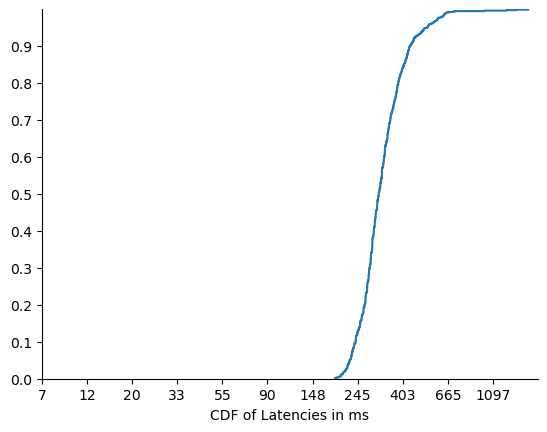

<Figure size 640x480 with 0 Axes>

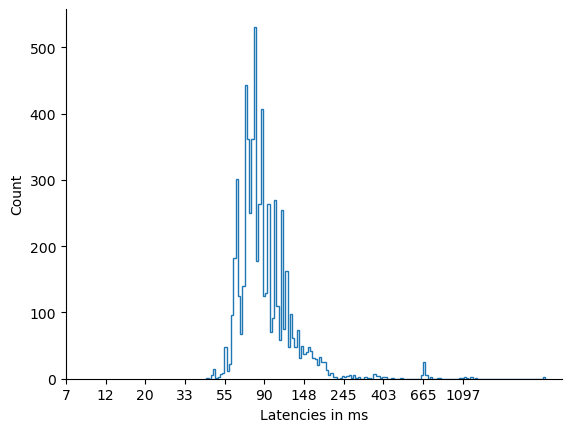

<Figure size 640x480 with 0 Axes>

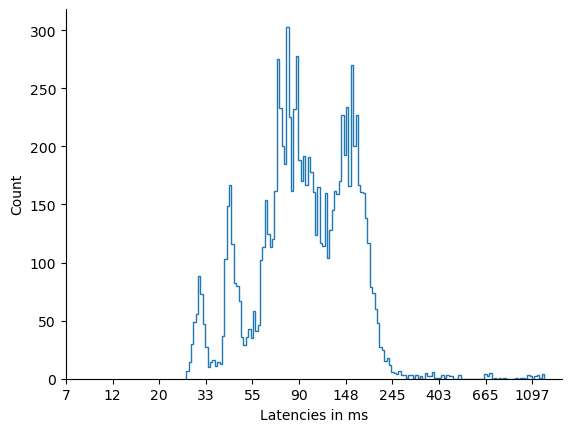

<Figure size 640x480 with 0 Axes>

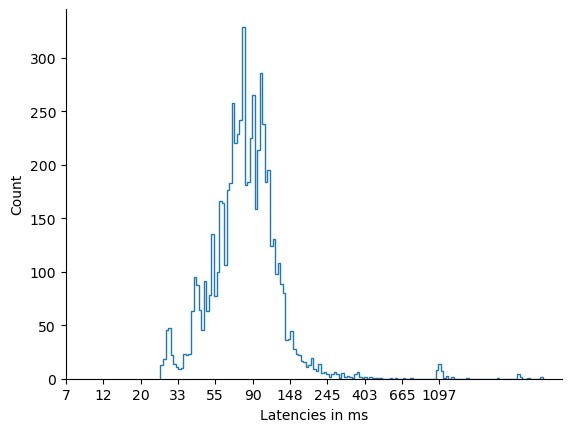

<Figure size 640x480 with 0 Axes>

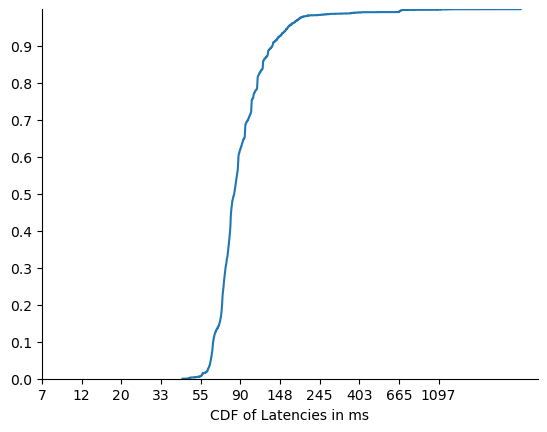

<Figure size 640x480 with 0 Axes>

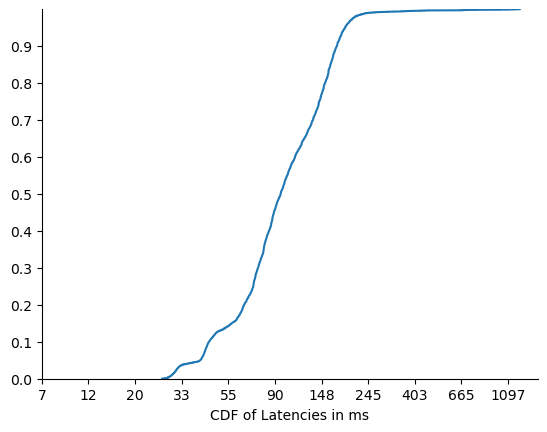

<Figure size 640x480 with 0 Axes>

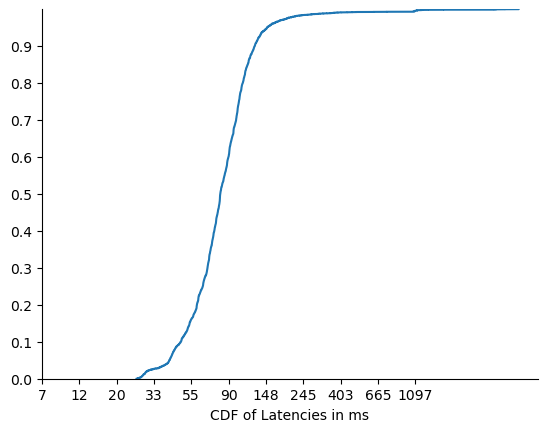

<Figure size 640x480 with 0 Axes>

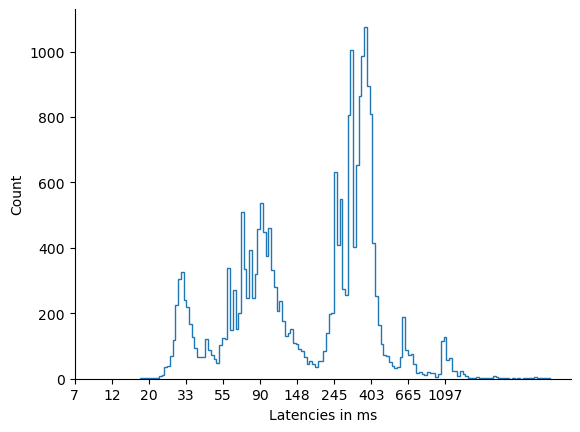

<Figure size 640x480 with 0 Axes>

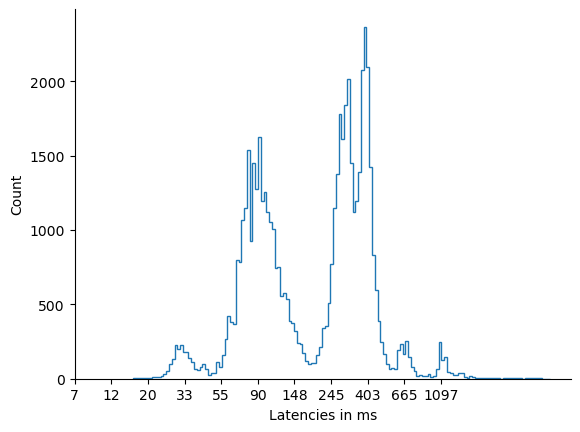

<Figure size 640x480 with 0 Axes>

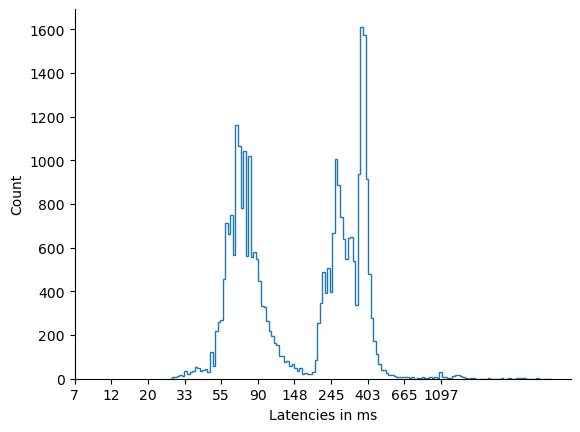

<Figure size 640x480 with 0 Axes>

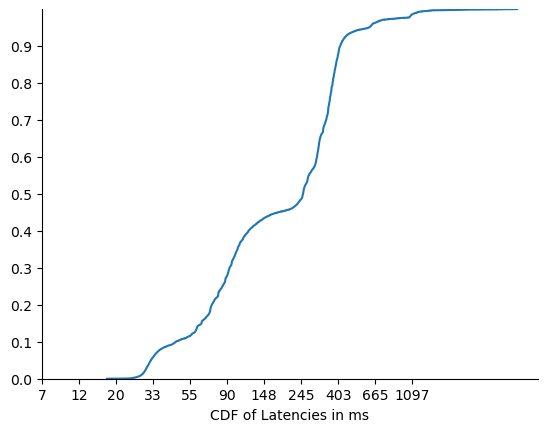

<Figure size 640x480 with 0 Axes>

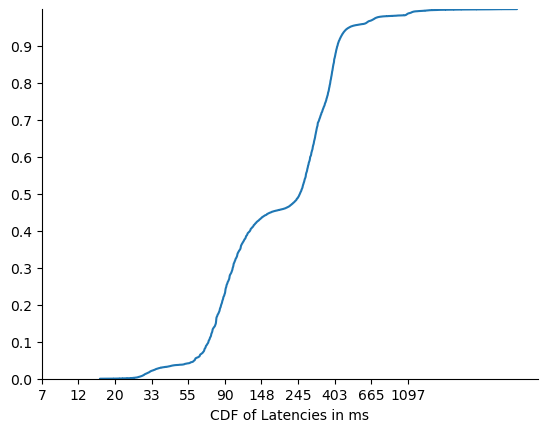

<Figure size 640x480 with 0 Axes>

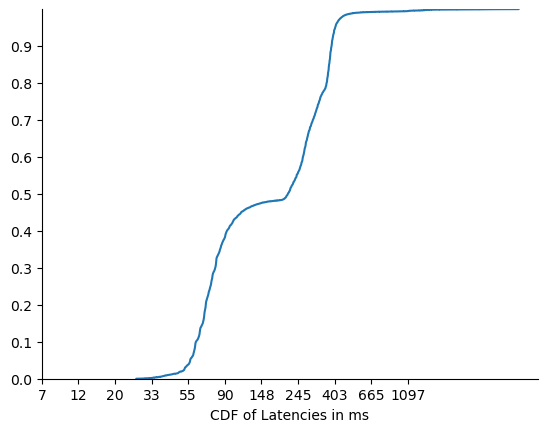

<Figure size 640x480 with 0 Axes>

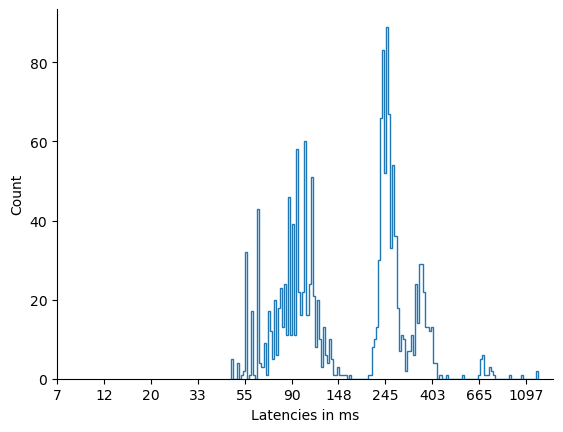

<Figure size 640x480 with 0 Axes>

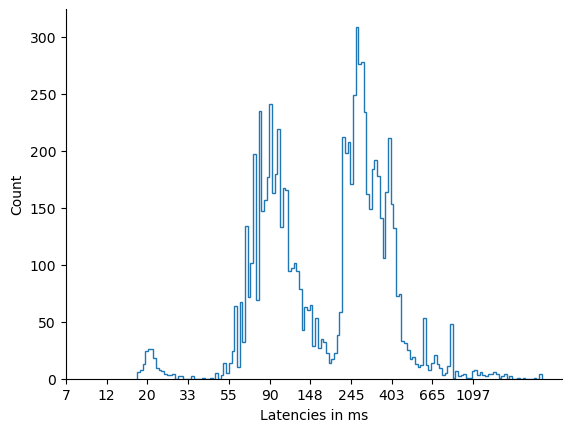

<Figure size 640x480 with 0 Axes>

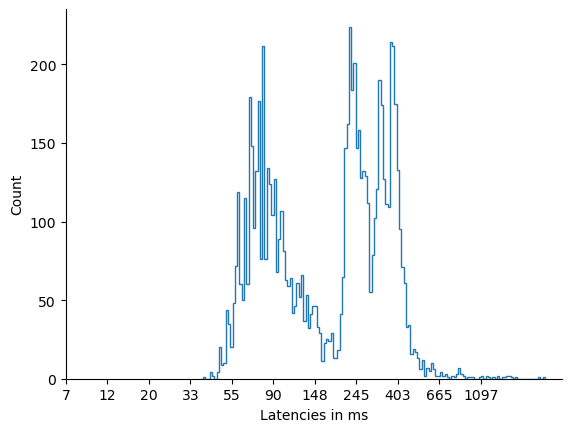

<Figure size 640x480 with 0 Axes>

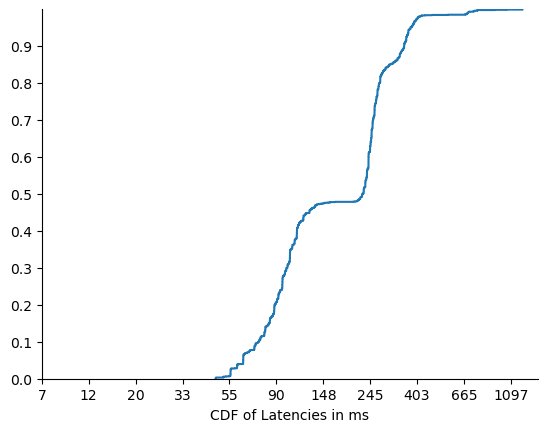

<Figure size 640x480 with 0 Axes>

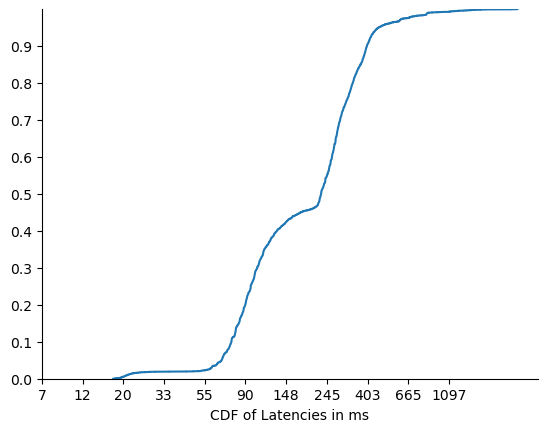

<Figure size 640x480 with 0 Axes>

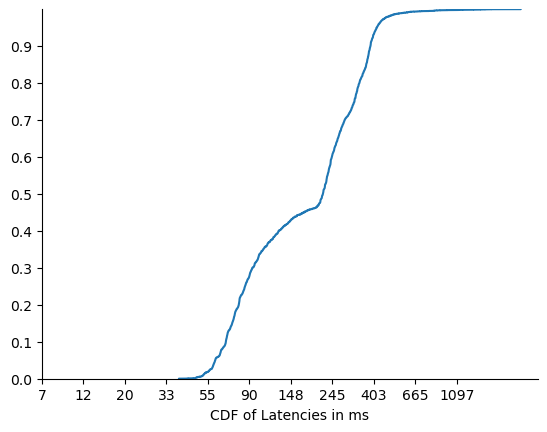

<Figure size 640x480 with 0 Axes>

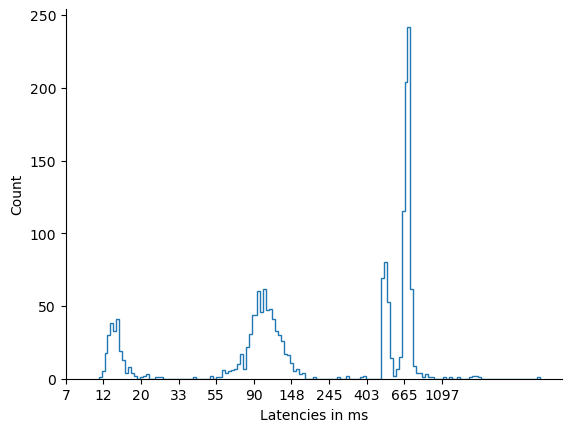

<Figure size 640x480 with 0 Axes>

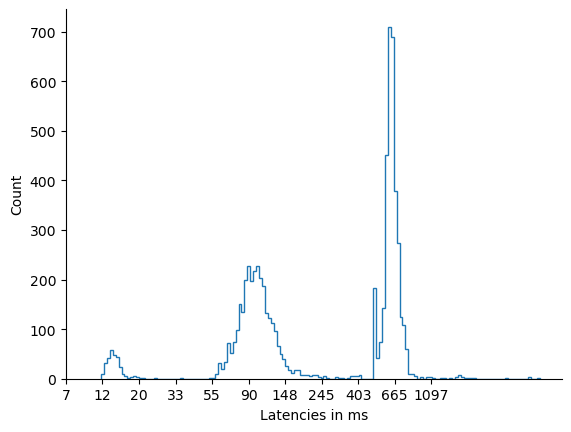

<Figure size 640x480 with 0 Axes>

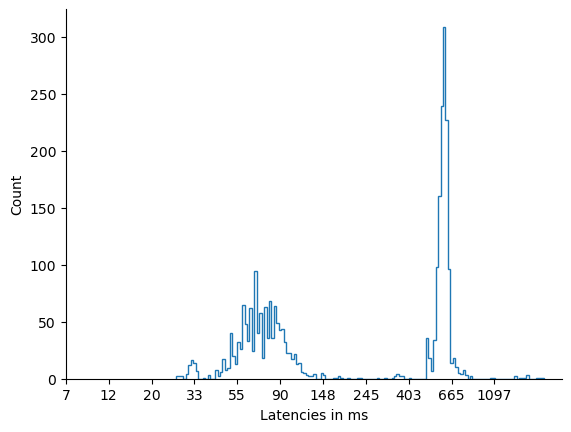

<Figure size 640x480 with 0 Axes>

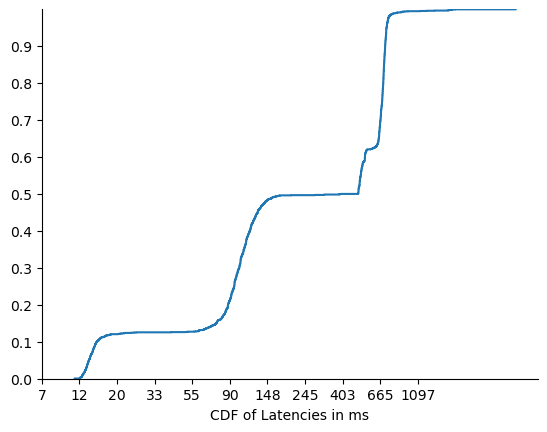

<Figure size 640x480 with 0 Axes>

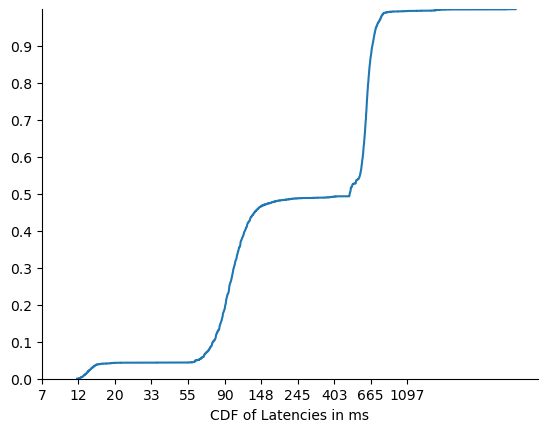

<Figure size 640x480 with 0 Axes>

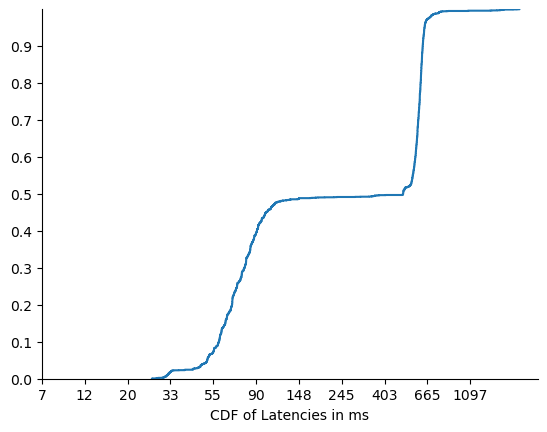

<Figure size 640x480 with 0 Axes>

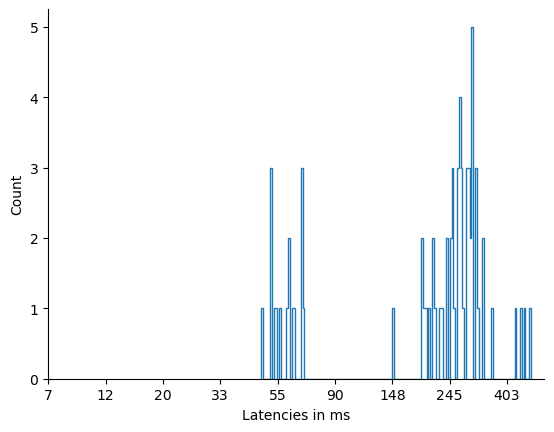

<Figure size 640x480 with 0 Axes>

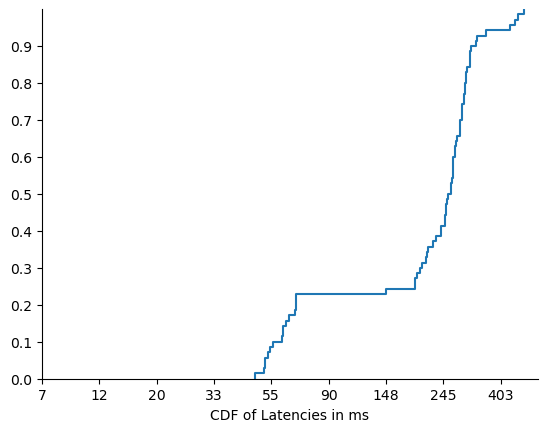

<Figure size 640x480 with 0 Axes>

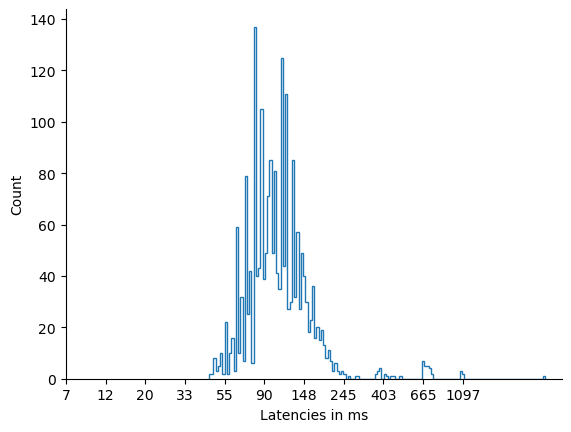

<Figure size 640x480 with 0 Axes>

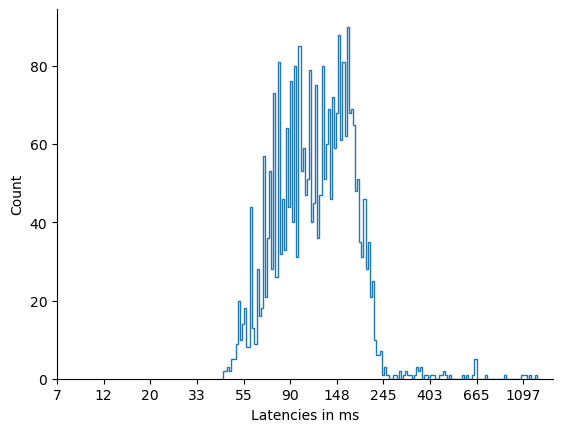

<Figure size 640x480 with 0 Axes>

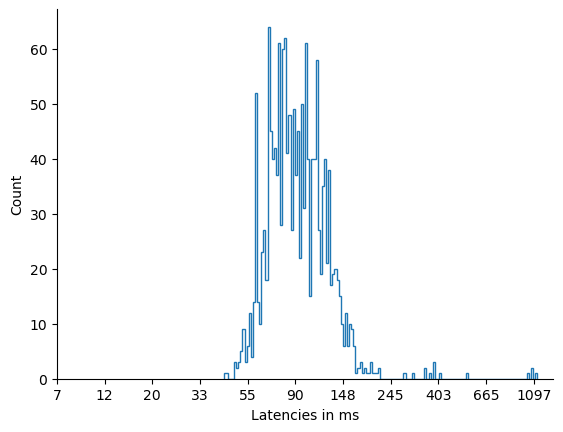

<Figure size 640x480 with 0 Axes>

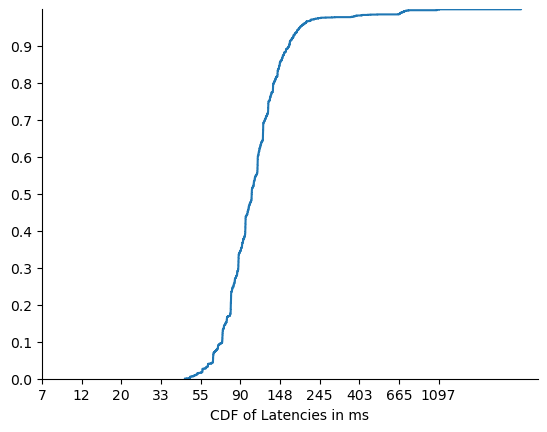

<Figure size 640x480 with 0 Axes>

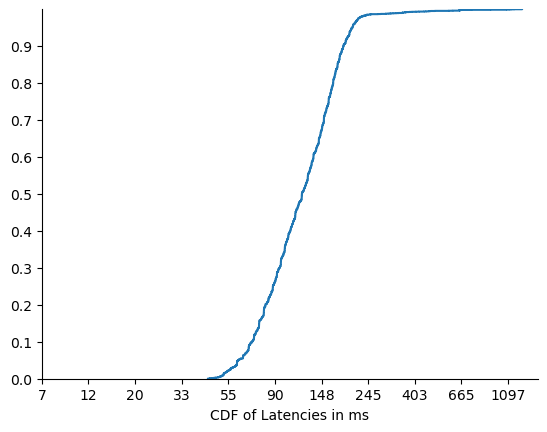

<Figure size 640x480 with 0 Axes>

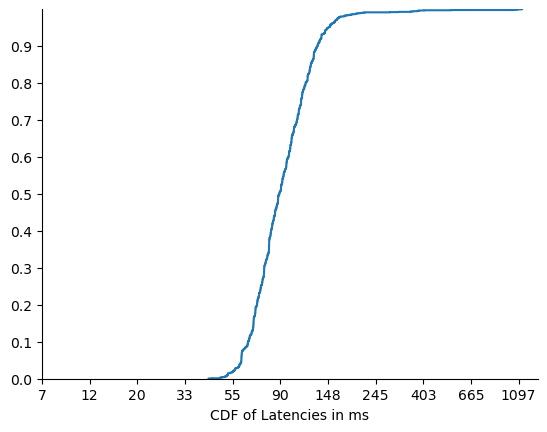

<Figure size 640x480 with 0 Axes>

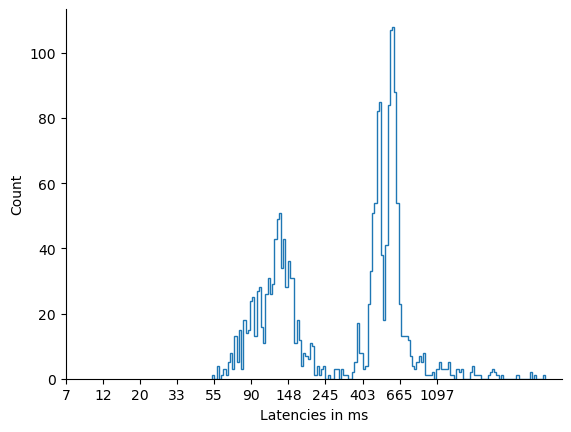

<Figure size 640x480 with 0 Axes>

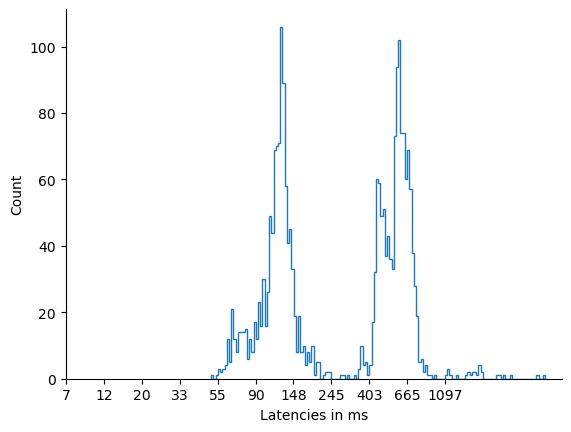

<Figure size 640x480 with 0 Axes>

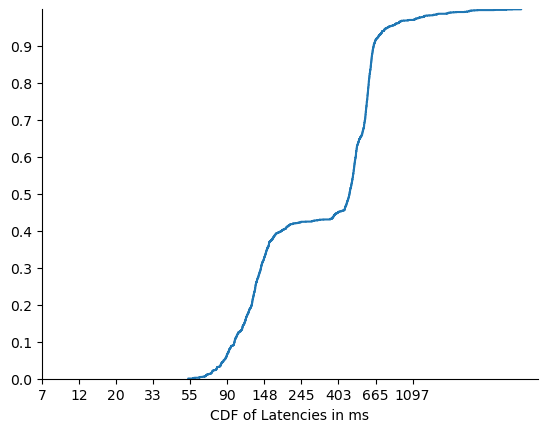

<Figure size 640x480 with 0 Axes>

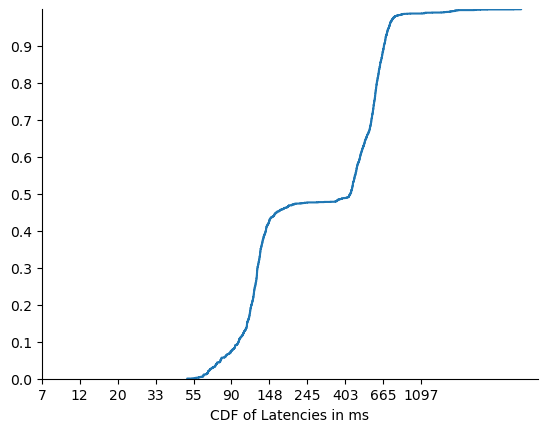

<Figure size 640x480 with 0 Axes>

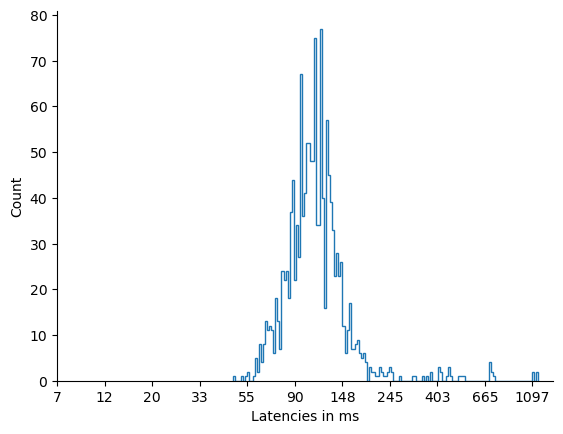

<Figure size 640x480 with 0 Axes>

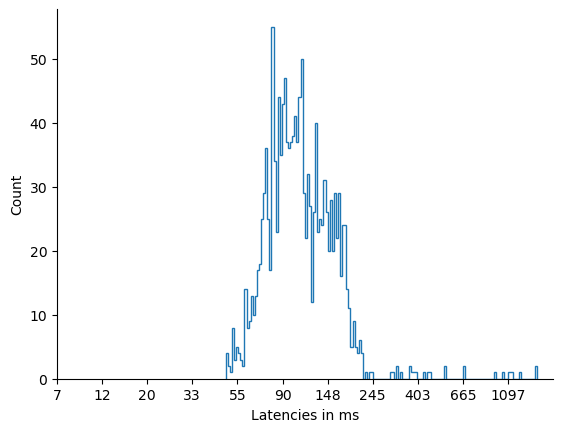

<Figure size 640x480 with 0 Axes>

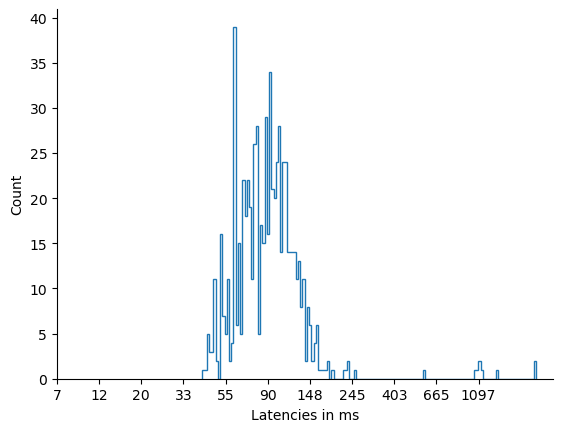

<Figure size 640x480 with 0 Axes>

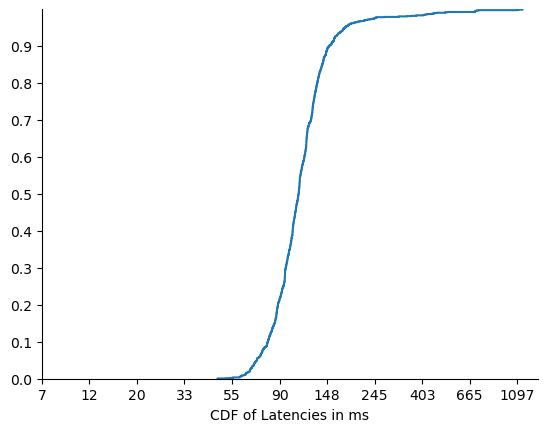

<Figure size 640x480 with 0 Axes>

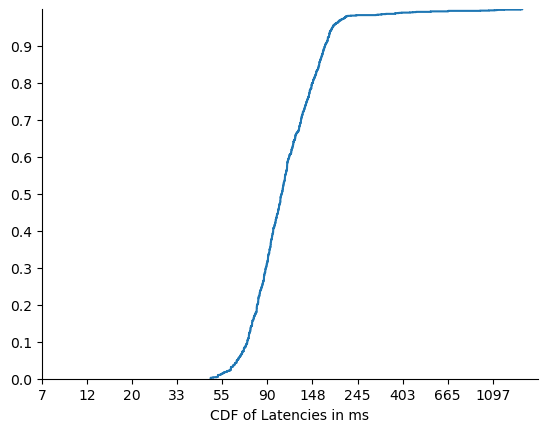

<Figure size 640x480 with 0 Axes>

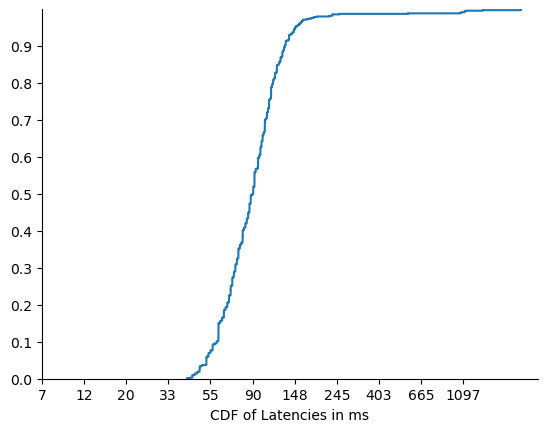

<Figure size 640x480 with 0 Axes>

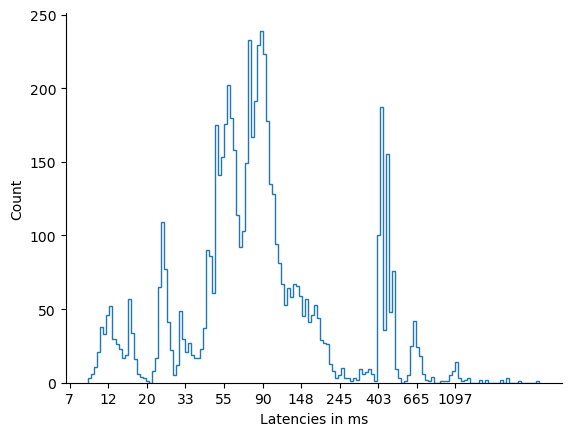

<Figure size 640x480 with 0 Axes>

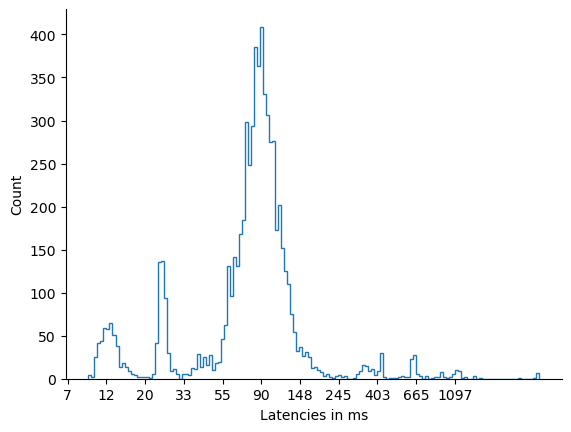

<Figure size 640x480 with 0 Axes>

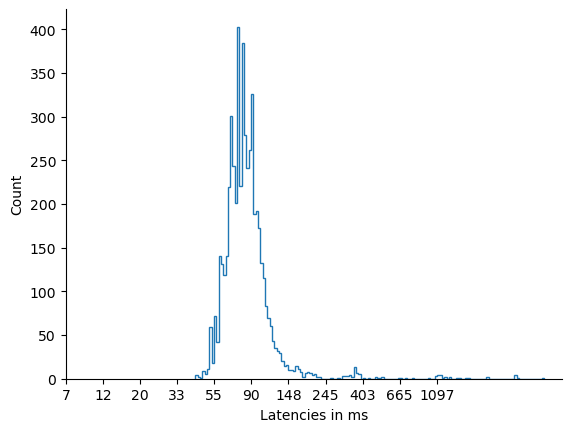

<Figure size 640x480 with 0 Axes>

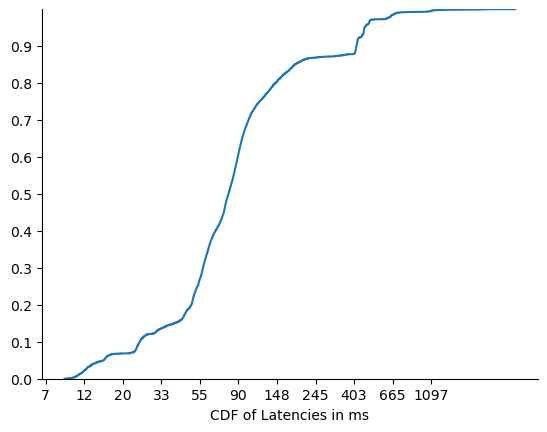

<Figure size 640x480 with 0 Axes>

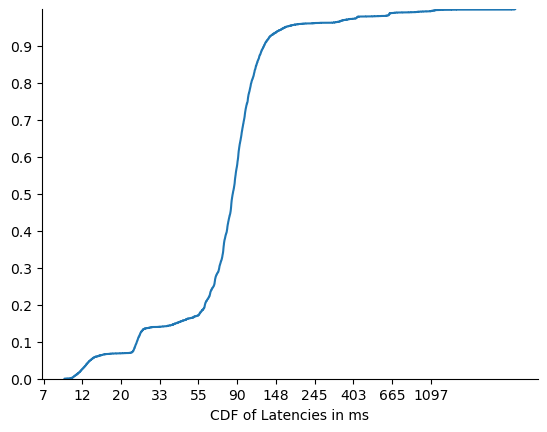

<Figure size 640x480 with 0 Axes>

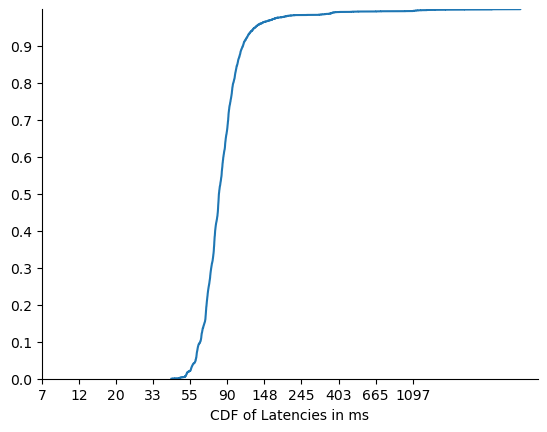

<Figure size 640x480 with 0 Axes>

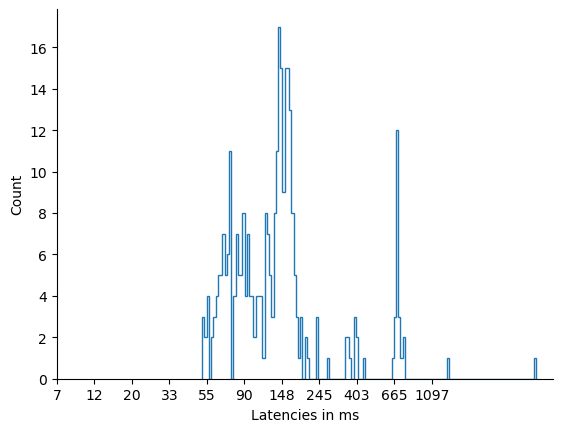

<Figure size 640x480 with 0 Axes>

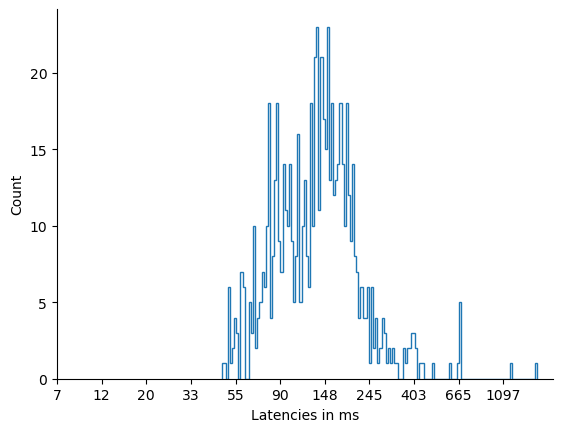

<Figure size 640x480 with 0 Axes>

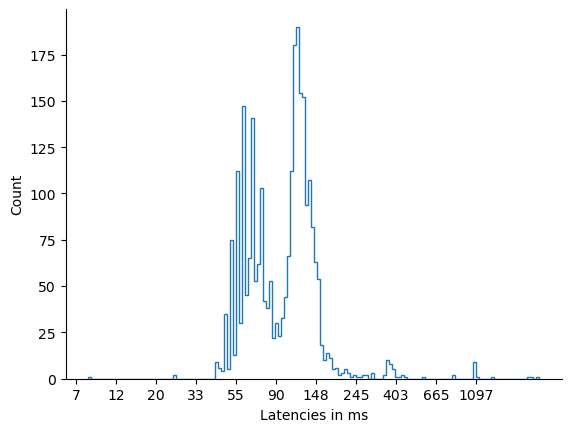

<Figure size 640x480 with 0 Axes>

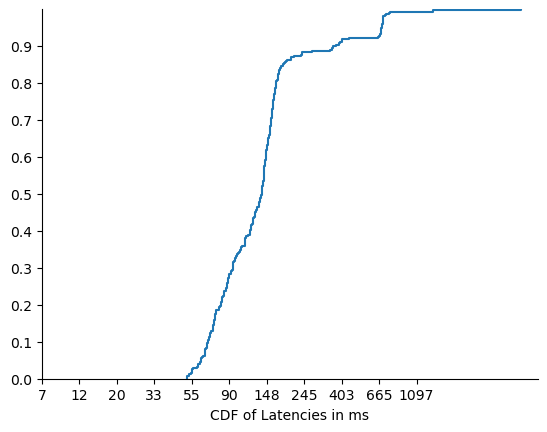

<Figure size 640x480 with 0 Axes>

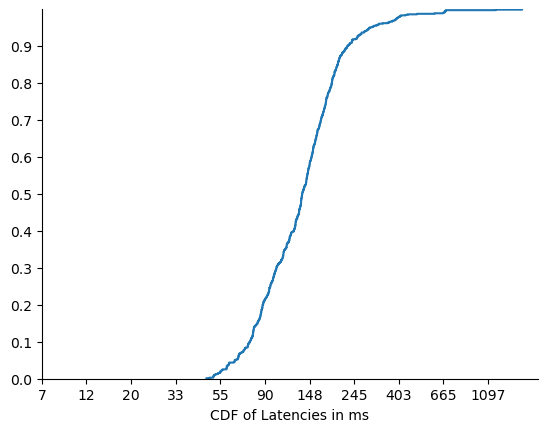

<Figure size 640x480 with 0 Axes>

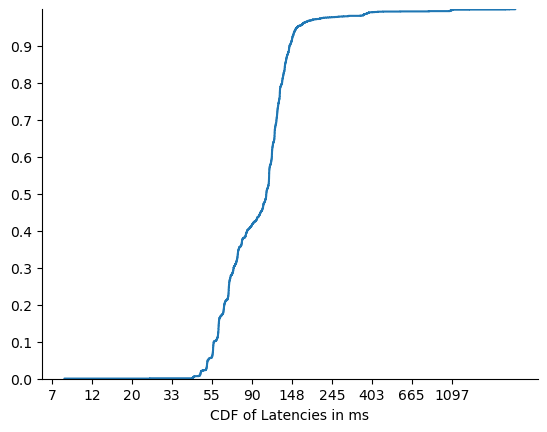

<Figure size 640x480 with 0 Axes>

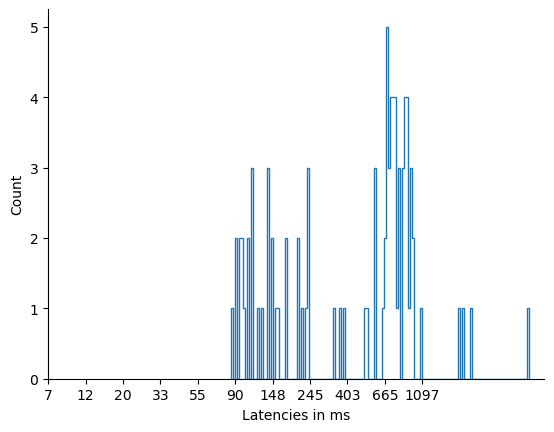

<Figure size 640x480 with 0 Axes>

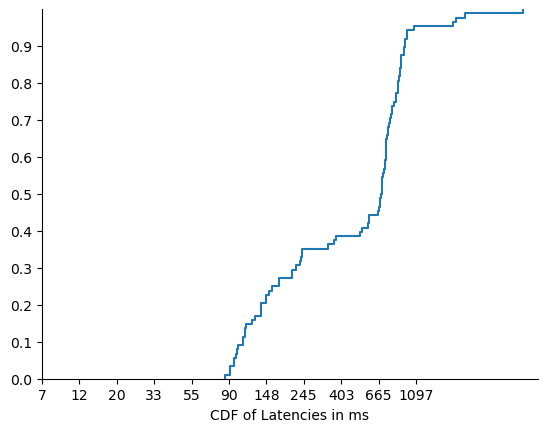

<Figure size 640x480 with 0 Axes>

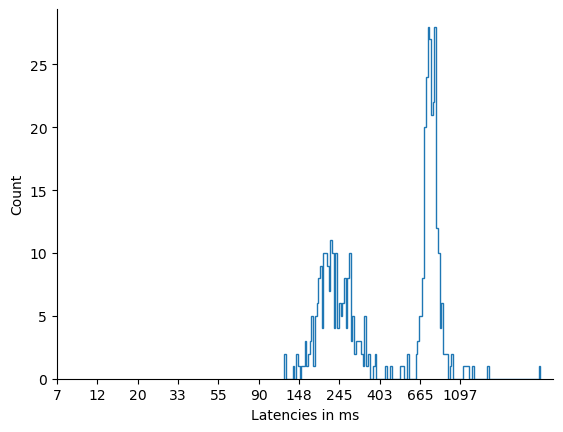

<Figure size 640x480 with 0 Axes>

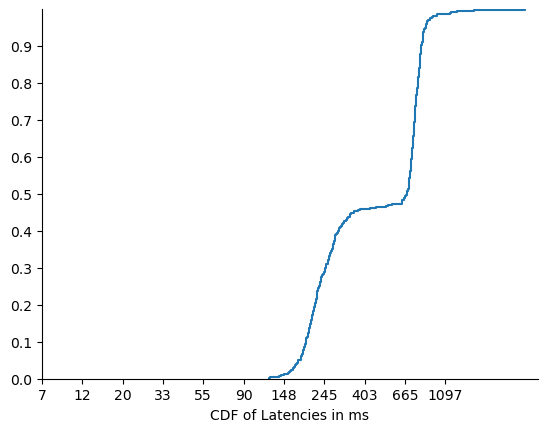

<Figure size 640x480 with 0 Axes>

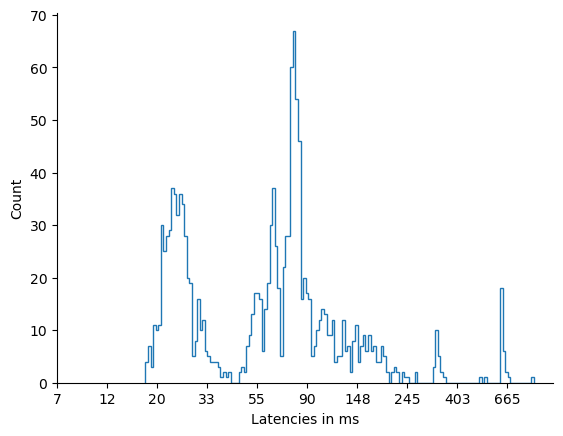

<Figure size 640x480 with 0 Axes>

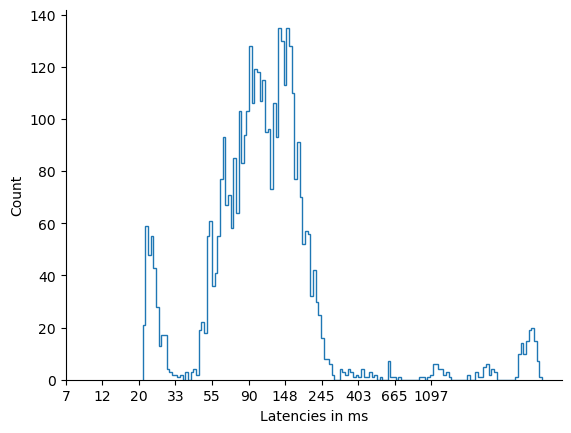

<Figure size 640x480 with 0 Axes>

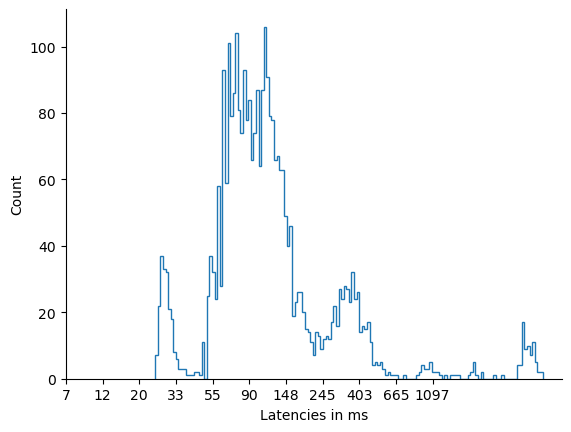

<Figure size 640x480 with 0 Axes>

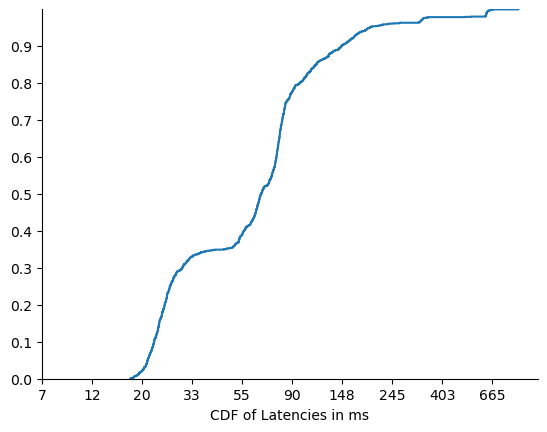

<Figure size 640x480 with 0 Axes>

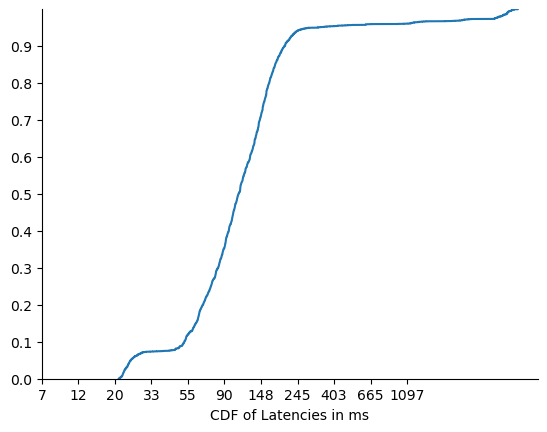

<Figure size 640x480 with 0 Axes>

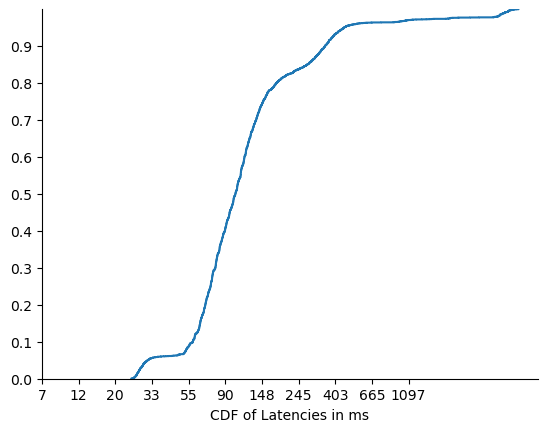

<Figure size 640x480 with 0 Axes>

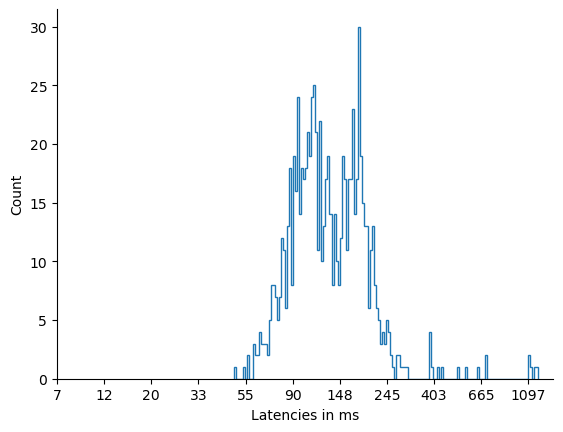

<Figure size 640x480 with 0 Axes>

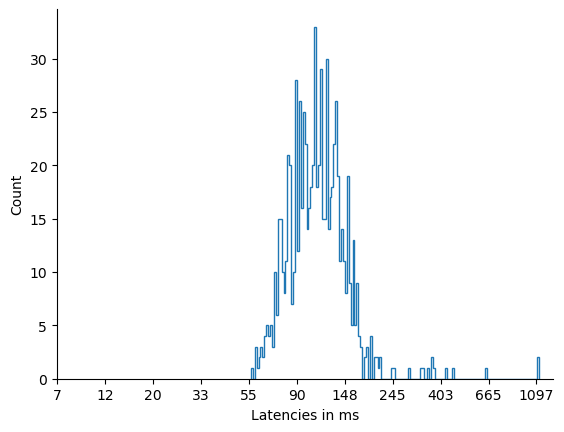

<Figure size 640x480 with 0 Axes>

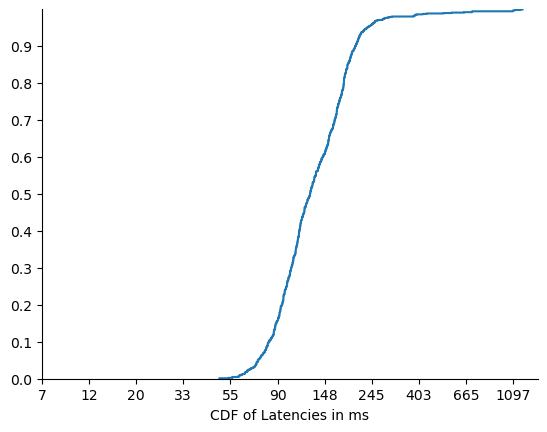

<Figure size 640x480 with 0 Axes>

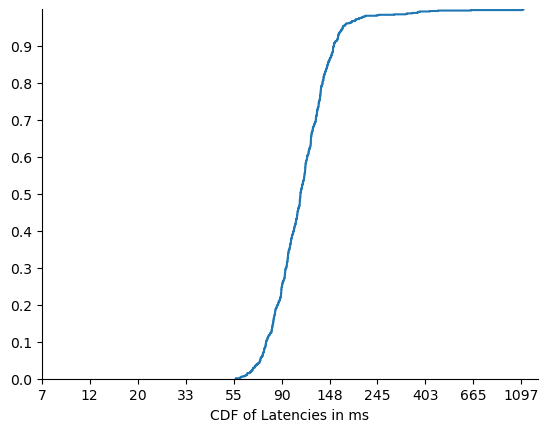

<Figure size 640x480 with 0 Axes>

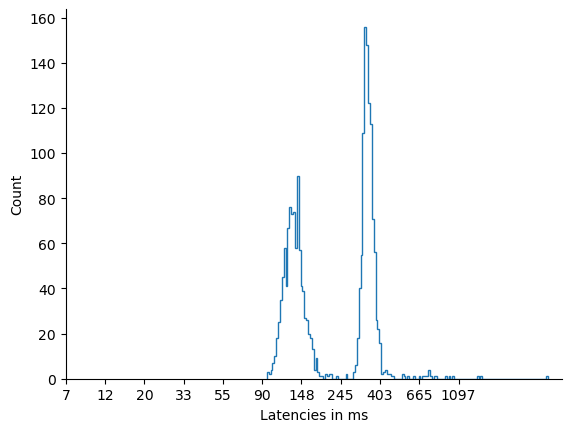

<Figure size 640x480 with 0 Axes>

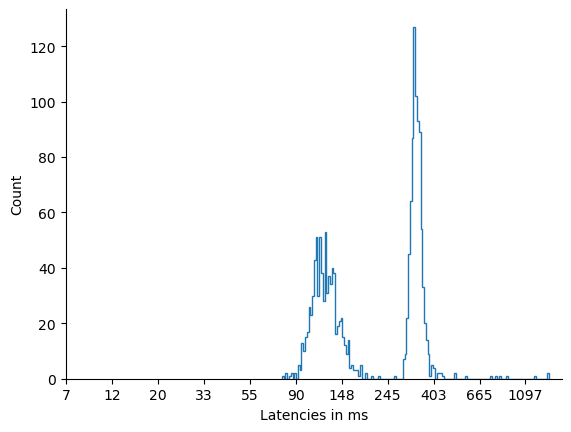

<Figure size 640x480 with 0 Axes>

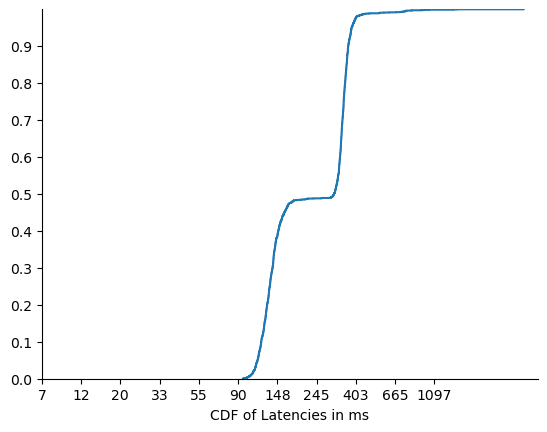

<Figure size 640x480 with 0 Axes>

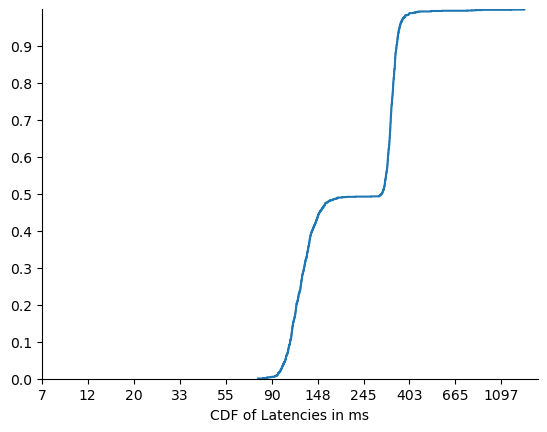

<Figure size 640x480 with 0 Axes>

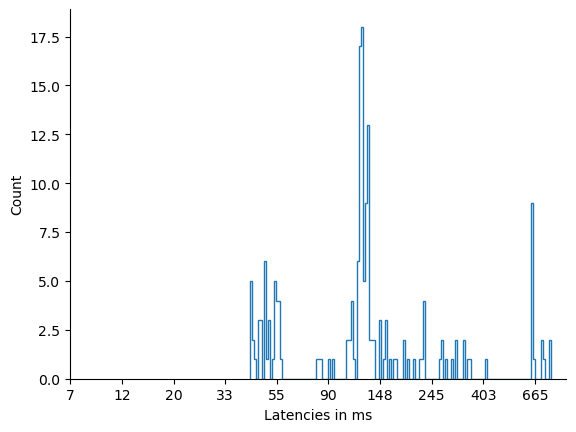

<Figure size 640x480 with 0 Axes>

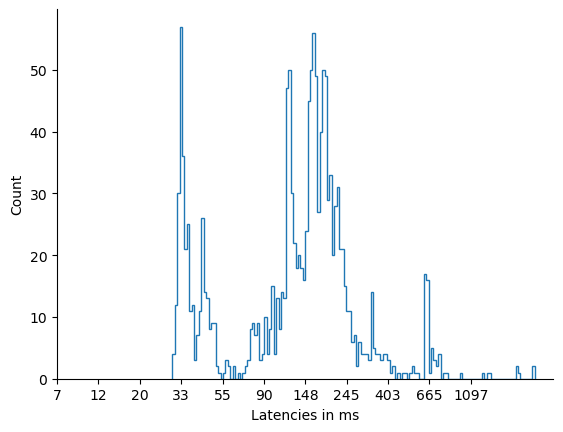

<Figure size 640x480 with 0 Axes>

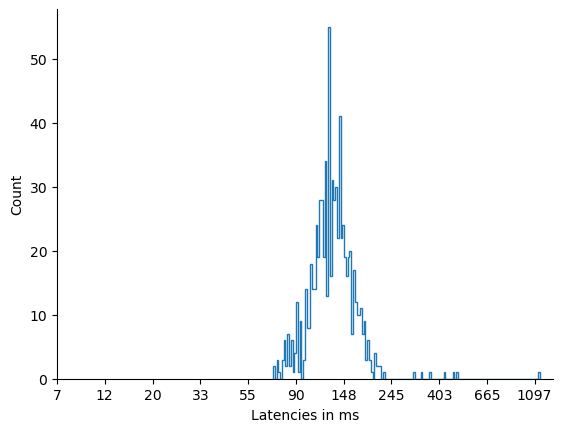

<Figure size 640x480 with 0 Axes>

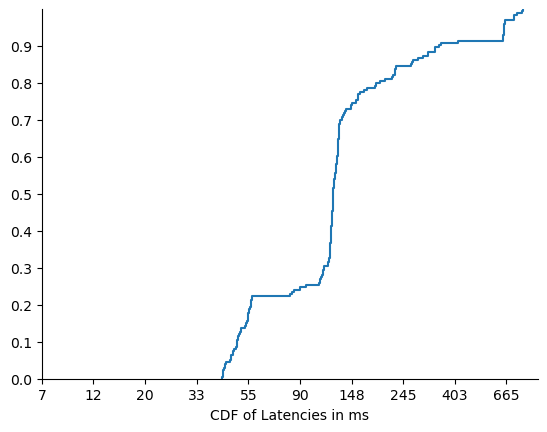

<Figure size 640x480 with 0 Axes>

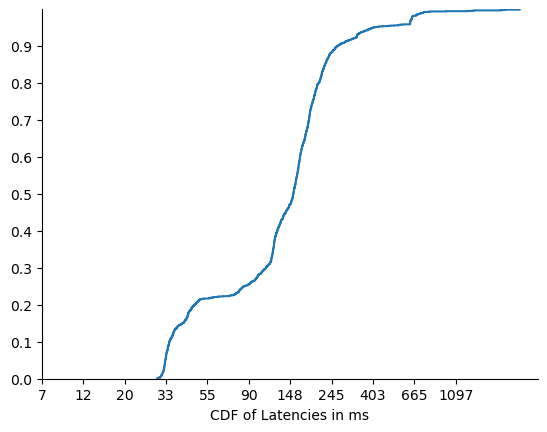

<Figure size 640x480 with 0 Axes>

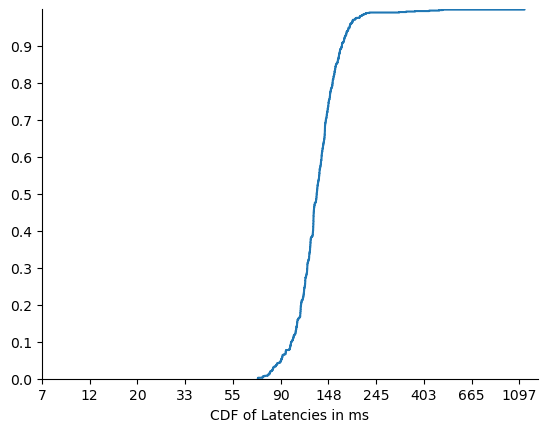

<Figure size 640x480 with 0 Axes>

In [3]:
results_dir = './cdf'

start2022 = datetime(2022, 1, 1).timestamp()
start2023 = datetime(2023, 1, 1).timestamp()
start2024 = datetime(2024, 1, 1).timestamp()
future = datetime(2030, 1, 1).timestamp()

df2022 = filter_for_range(df, 'timestamp', start2022, start2023)
df2023 = filter_for_range(df, 'timestamp', start2023, start2024)
df2024 = filter_for_range(df, 'timestamp', start2024, future)

def per_country_cdf(unfiltered_df, c, title):
    df = filter_for(unfiltered_df, 'country', c)
    
    rt_column = [v for v in df['rt'].tolist() if v > 0]
    log_rts = np.log(rt_column)

    if len(log_rts) == 0 or len(df) == 0: return
    
    fig, ax = plt.subplots()
    ax.ecdf(log_rts)
    ax.set_xlabel('CDF of Latencies in ms')

    pred = 1200
    xticks_locations = [v for v in np.arange(2, np.max(log_rts), 0.5) if v < math.log(pred)]
    xticks_labels = [str(int(v)) for v in np.round(np.exp(xticks_locations), 0) if v < pred]

    plt.xticks(xticks_locations, xticks_labels)
    plt.yticks(np.arange(0, 1, 0.1))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.spines[['right', 'top']].set_visible(False)
    plt.savefig(results_dir + "/cdf_" + title.lower().replace(" ", "_") + ".pdf")
    plt.show()
    plt.clf()

def per_country_histogram(unfiltered_df, c, title):
    df = filter_for(unfiltered_df, 'country', c)
    
    rt_column = [v for v in df['rt'].tolist() if v > 0]
    log_rts = np.log(rt_column)

    if len(log_rts) == 0 or len(df) == 0: return

    fig, ax = plt.subplots()
    ax.set_xlabel('Latencies in ms')
    ax.set_ylabel('Count')

    pred = 1200
    xticks_locations = [v for v in np.arange(2, np.max(log_rts), 0.5) if v < math.log(pred)]
    xticks_labels = [str(int(v)) for v in np.round(np.exp(xticks_locations), 0) if v < pred]

    counts, bins = np.histogram(log_rts, 150)
    ax.stairs(counts, bins)

    plt.xticks(xticks_locations, xticks_labels)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.spines[['right', 'top']].set_visible(False)
    plt.savefig(results_dir + "/" + title.lower().replace(" ", "_") + ".pdf")
    plt.show()
    plt.clf()

if not os.path.isdir(results_dir): os.mkdir(results_dir)
for country in set(df['country'].tolist()):
    if type(country) is not str: continue
    
    per_country_histogram(df2022, country, 'Histogram of Latencies in 2022 of Starlink Probes in ' + country_name(country)) 
    per_country_histogram(df2023, country, 'Histogram of Latencies in 2023 of Starlink Probes in ' + country_name(country))
    per_country_histogram(df2024, country, 'Histogram of Latencies in 2024 of Starlink Probes in ' + country_name(country))
    per_country_cdf(df2022, country, 'Latencies in 2022 of Starlink Probes in ' + country_name(country))
    per_country_cdf(df2023, country, 'Latencies in 2023 of Starlink Probes in ' + country_name(country))
    per_country_cdf(df2024, country, 'Latencies in 2024 of Starlink Probes in ' + country_name(country))
